**Libraries**

In [1]:
import numpy as np
from astropy.io import fits
from scipy.signal import correlate

import stats
import plot_module as plot
import bloodmoon as bm

In [67]:
import importlib
importlib.reload(plot)

<module 'plot_module' from '/home/starfloyd/PhD_Coding/MasksReconstructionTest/Img_Reconstruction_RealMasks/plot_module.py'>

# <center>**Opening .fits Images**<center>

In [2]:
fits_path = "../Images_fits/wfm_mask.fits"

**Opening with BloodMoon**

In [3]:
wfm = bm.codedmask(fits_path)

### Camera Parameters
mask_minx: -130.0
mask_miny: -130.0
mask_maxx: 130.0
mask_maxy: 130.0
mask_deltax: 0.25
mask_deltay: 0.4
mask_thickness: 0.15
slit_deltax: 0.25
slit_deltay: 14.0
detector_minx: -78.988
detector_maxx: 78.988
detector_miny: -76.5255
detector_maxy: 76.5255
mask_detector_distance: 202.9

### Shapes
Mask shape: (650, 1040)
Detector shape: (384, 632)
Sky shape: (1033, 1671)


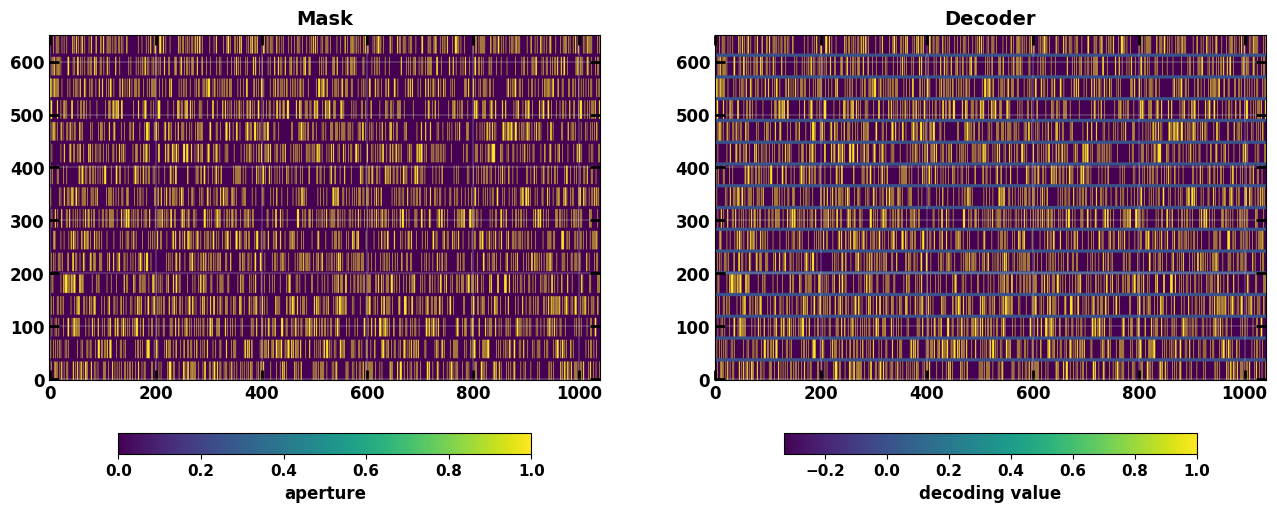

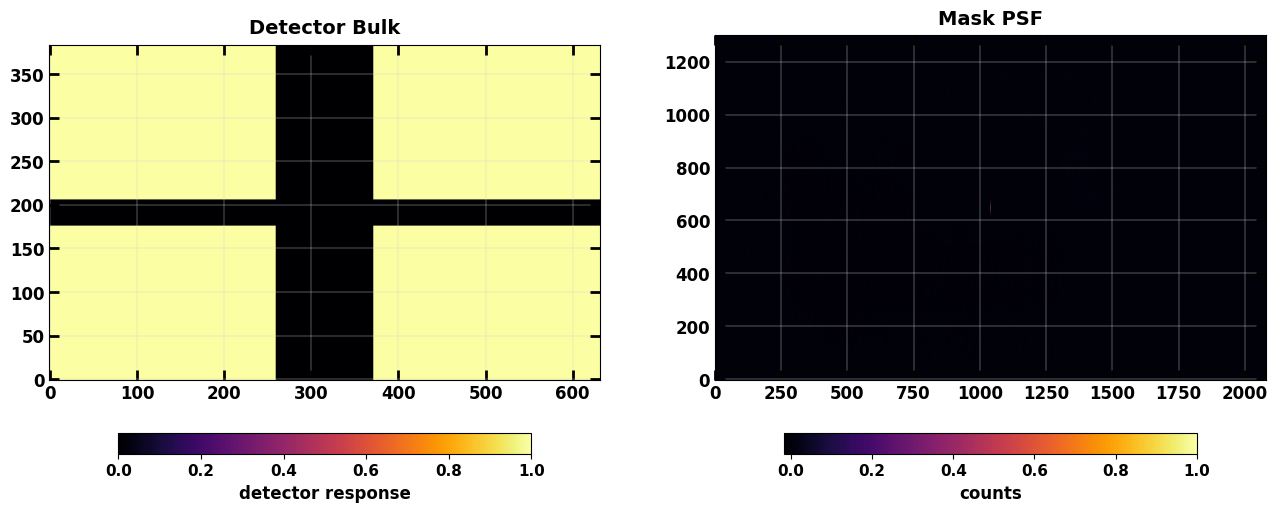

In [4]:
print("### Camera Parameters")
for key, value in wfm.specs.items():
    print(f"{key}: {value}")
       
print(f"\n### Shapes\n"
      f"Mask shape: {wfm.mask_shape}\n"
      f"Detector shape: {wfm.detector_shape}\n"
      f"Sky shape: {wfm.sky_shape}")

plot.image_plot([wfm.mask, wfm.decoder],
                ["Mask", "Decoder"],
                cbarlabel=["aperture", "decoding value"], 
                cbarcmap=["viridis"]*2)

psf = correlate(wfm.mask, wfm.decoder)/wfm.mask.sum()

plot.image_plot([wfm.bulk, psf],
                ["Detector Bulk", "Mask PSF"],
                cbarlabel=["detector response", "counts"],
                cbarscinot=[False, True],
                cbarcmap=["inferno"]*2)

assert psf.shape == (1299, 2079)

In [29]:
from bloodmoon.images import upscale

arr = np.array([
    [1, 2],
    [3, 4],
    [5, 6]
])

# no magic here, `upscale` will just repeat elements along each dimension.
# note that, for compatibility, we use `x` and `y` and not `rows` and `cols`
upscale(arr, upscale_x=3, upscale_y=2)

array([[1, 1, 1, 2, 2, 2],
       [1, 1, 1, 2, 2, 2],
       [3, 3, 3, 4, 4, 4],
       [3, 3, 3, 4, 4, 4],
       [5, 5, 5, 6, 6, 6],
       [5, 5, 5, 6, 6, 6]])

**Opening with Astropy**

In [ ]:
header = dict(fits.getheader(fits_path, ext=0)) | dict(fits.getheader(fits_path, ext=2))

mask = fits.getdata(fits_path, ext=2)
decoder = fits.getdata(fits_path, ext=3)
bulk = fits.getdata(fits_path, ext=4)

# fits.getdata(fits_path, ext=0)  # no data
fits.getdata(fits_path, ext=1)

FITS_rec([(-129.875, -129.8, 1.), (-129.625, -129.8, 0.),
          (-129.375, -129.8, 0.), ..., ( 129.375,  129.8, 0.),
          ( 129.625,  129.8, 0.), ( 129.875,  129.8, 1.)],
         shape=(676000,), dtype=(numpy.record, [('X', '>f4'), ('Y', '>f4'), ('VAL', '>f4')]))

# <center>**Basic Simulation**<center>

In [4]:
import collections.abc as c

def sky_image_simulation(sky_image_shape: tuple[int, int],
                         sources_flux: c.Sequence[int],
                         sources_pos: None | c.Sequence[tuple[int, int]] = None,
                         sky_background_rate: None | int = None,
                         ) -> tuple[c.Sequence, c.Sequence, c.Sequence]:
    """Simulates the sky image given the sources flux."""

    # generate sky
    if sky_background_rate is None:
        sky_image = np.zeros(sky_image_shape)
    else:
        sky_image = np.random.poisson(sky_background_rate, sky_image_shape)
    
    sky_background = sky_image.copy()

    if sources_pos is None:
        sources_pos = [(np.random.randint(0, sky_image_shape[0]), np.random.randint(0, sky_image_shape[1]))
                       for _ in range(len(sources_flux))]

    # assign fluxes to point-like sources
    for i, pos in enumerate(sources_pos):
        sky_image[pos[0], pos[1]] = sources_flux[i]
    
    return sky_image, sky_background, sources_pos

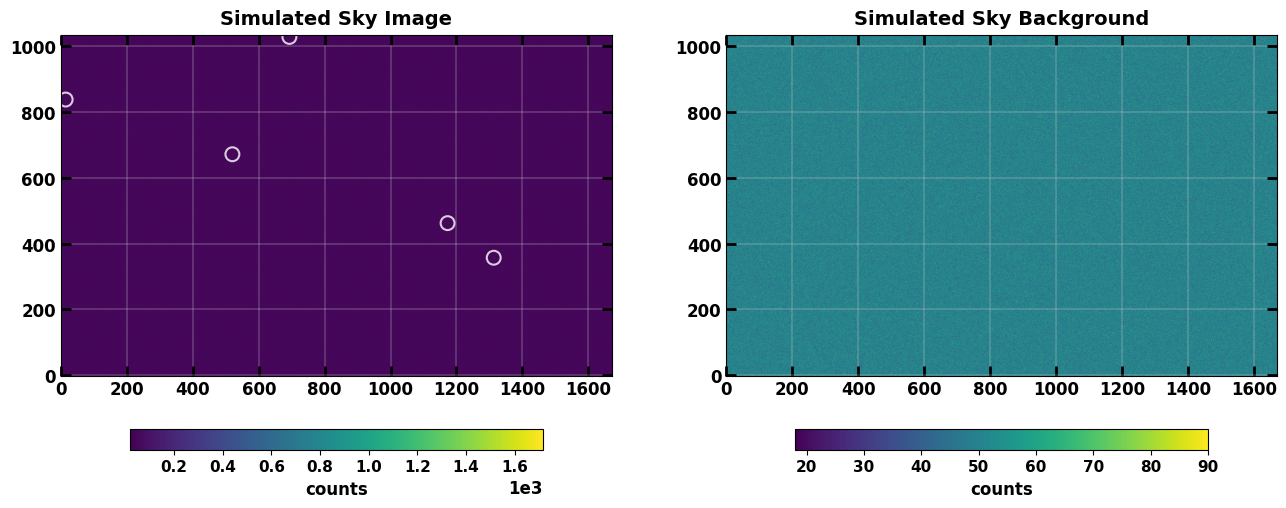

In [5]:
n_sources = 5
sources_flux = np.random.randint(int(5e2), int(2e3), size=n_sources)
sources_pos = None
sky_background_rate = int(5e1)

sky_image, sky_background, sources_pos = sky_image_simulation(wfm.sky_shape, sources_flux, sources_pos, sky_background_rate)

plot.image_plot([sky_image, sky_background],
                ["Simulated Sky Image", "Simulated Sky Background"],
                cbarlabel=["counts", "counts"],
                cbarcmap=["viridis"]*2,
                simulated_sources=[sources_pos, None])

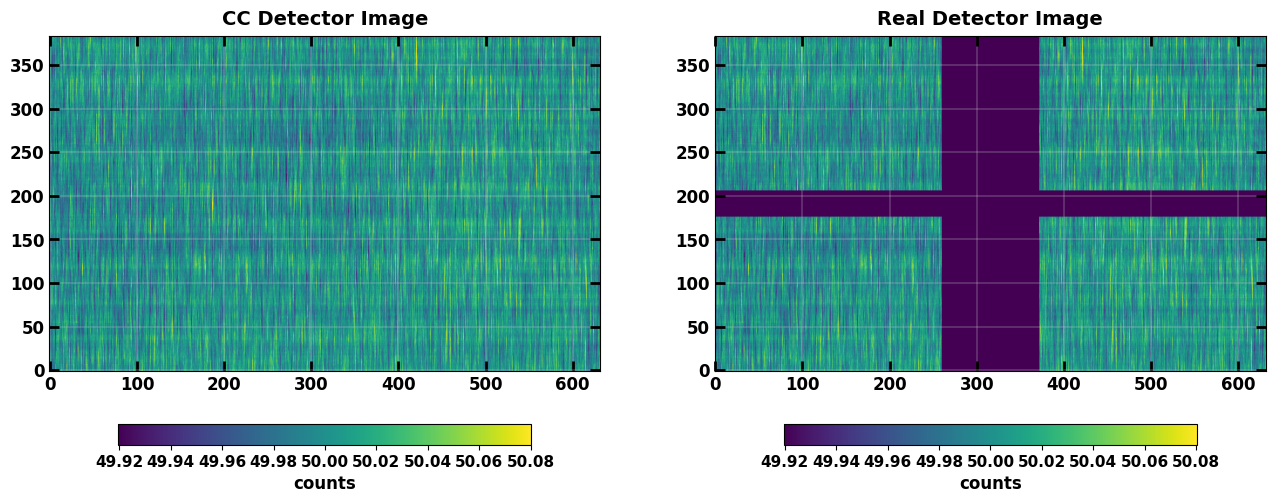

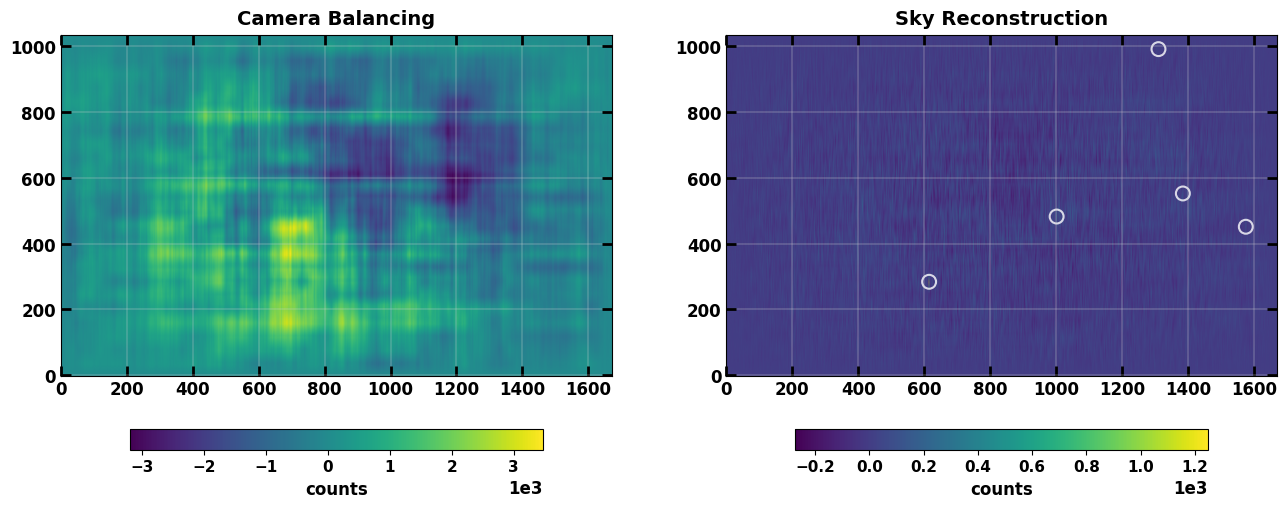

In [7]:
cc_detector_image = correlate(wfm.mask, sky_image, mode='valid')/wfm.mask.sum()
assert cc_detector_image.shape == wfm.detector_shape

detector_image = cc_detector_image*wfm.bulk


plot.image_plot([cc_detector_image, detector_image],
                ["CC Detector Image", "Real Detector Image"],
                cbarlabel=["counts", "counts"],
                cbarlimits=[(None, None), (cc_detector_image.min(), None)],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2)

skyrec = correlate(wfm.decoder, detector_image, mode="full")
balancing_array = correlate(wfm.decoder, wfm.bulk, mode="full")
sum_det, sum_bulk = map(np.sum, (detector_image, wfm.bulk))

open_fraction = wfm.mask.sum()/wfm.mask.size
bal_skyrec = (skyrec - balancing_array*sum_det/sum_bulk)*(1 - open_fraction)/open_fraction

#q = 5e-5
plot.image_plot([balancing_array, bal_skyrec],
                ["Camera Balancing", "Sky Reconstruction"],
                cbarlabel=["counts", "counts"],
                #cbarlimits=[(None, None), (np.quantile(bal_skyrec, q), np.quantile(bal_skyrec, 1 - q))],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2,
                simulated_sources=[None, sources_pos])

show_slices = False
if show_slices:
    stats.enhance_skyrec_slices(bal_skyrec, sources_pos)

In [8]:
for idx, pos in enumerate(sources_pos):
    print(f"Simulated Source [{idx}] counts: {sky_image[*pos]}\n"
          f"Reconstructed Source [{idx}] counts: {bal_skyrec[*pos]:.0f}\n")

Simulated Source [0] counts: 1601
Reconstructed Source [0] counts: 235

Simulated Source [1] counts: 1837
Reconstructed Source [1] counts: 1248

Simulated Source [2] counts: 982
Reconstructed Source [2] counts: 30

Simulated Source [3] counts: 512
Reconstructed Source [3] counts: 239

Simulated Source [4] counts: 603
Reconstructed Source [4] counts: 468



# <center>**Variance and SNR**<center>

**BloodMoon**

In [8]:
from bloodmoon import decode, variance, snratio

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1970/3746807277.py:18: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["counts", "SNR[$\sigma$]"],
/tmp/ipykernel_1970/3746807277.py:29: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["significance[$\sigma$]", "SNR[$\sigma$]"],
/tmp/ipykernel_1970/3746807277.py:29: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["significance[$\sigma$]", "SNR[$\sigma$]"],


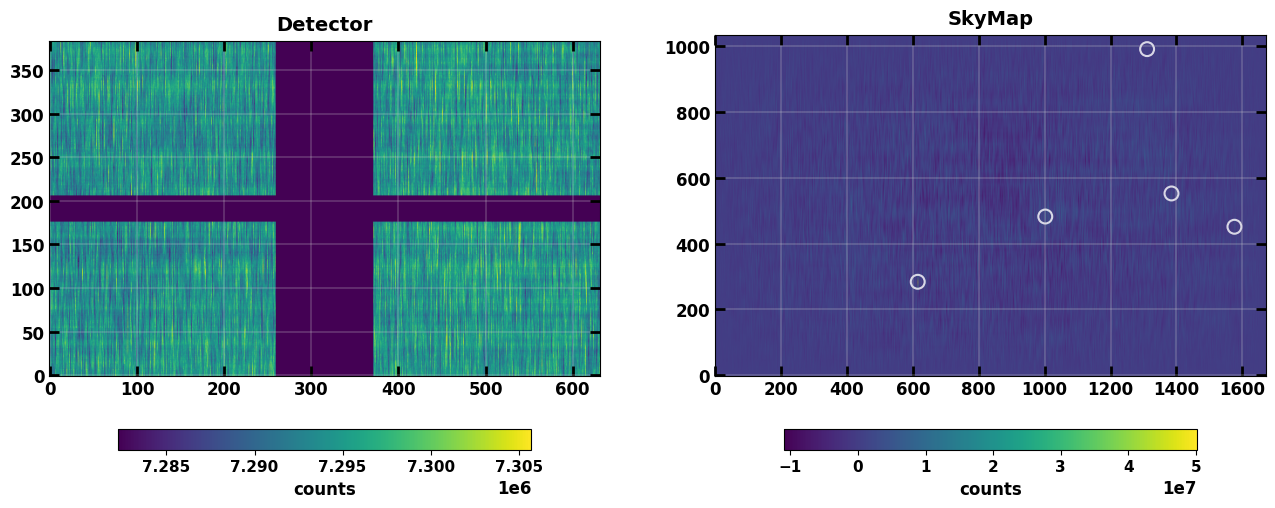

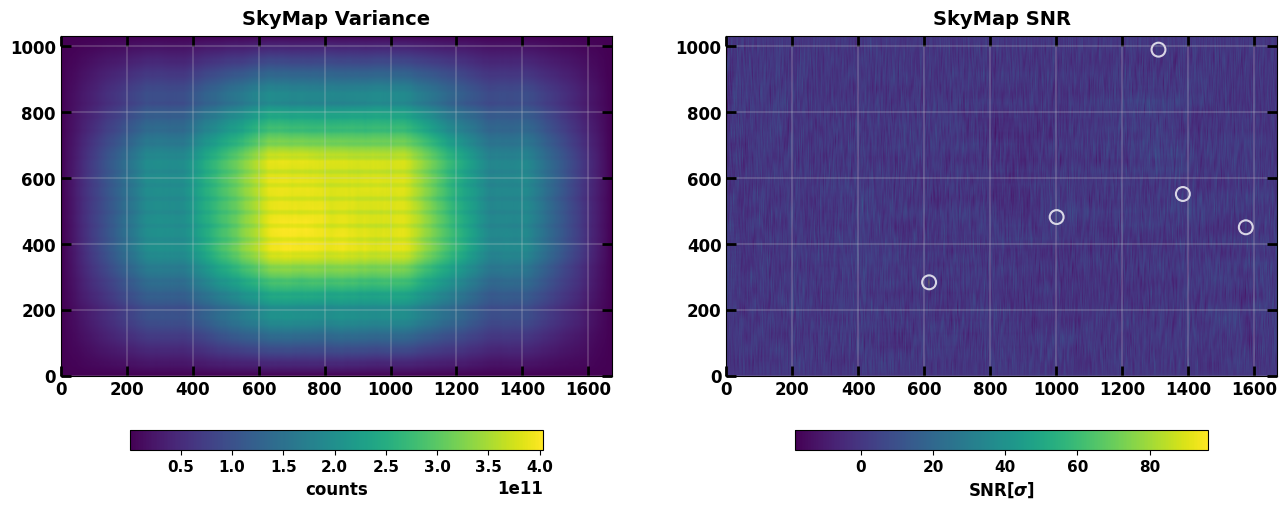

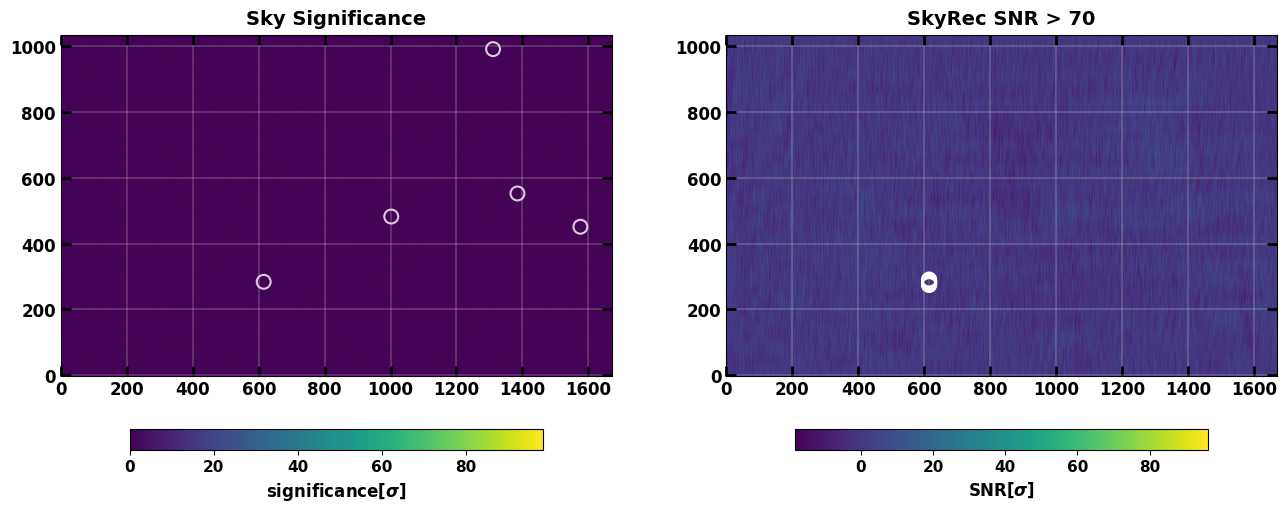

Simulated Source [0] counts: 1601
Reconstructed Source [0] renorm. counts: 235

Simulated Source [1] counts: 1837
Reconstructed Source [1] renorm. counts: 1248

Simulated Source [2] counts: 982
Reconstructed Source [2] renorm. counts: 30

Simulated Source [3] counts: 512
Reconstructed Source [3] renorm. counts: 239

Simulated Source [4] counts: 603
Reconstructed Source [4] renorm. counts: 468



In [10]:
cc_det = correlate(wfm.mask, sky_image, mode='valid')
det = cc_det*wfm.bulk
skymap = decode(wfm, det)

skymap_var = variance(wfm, det)
skymap_snr = snratio(skymap, skymap_var)

plot.image_plot([det, skymap],
                ["Detector", "SkyMap"],
                cbarlabel=["counts", "counts"],
                cbarlimits=[(cc_det.min(), None), (None, None)],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2,
                simulated_sources=[None, sources_pos])

plot.image_plot([skymap_var, skymap_snr],
                ["SkyMap Variance", "SkyMap SNR"],
                cbarlabel=["counts", "SNR[$\sigma$]"],
                cbarlimits=[(None, None), (None, None)],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2,
                simulated_sources=[None, sources_pos])

thres_snr = 70
loc = np.argwhere(skymap_snr > thres_snr).T

plot.image_plot([stats.significance(sky_image, sky_background_rate), skymap_snr],
                ["Sky Significance", f"SkyRec SNR > {thres_snr}"],
                cbarlabel=["significance[$\sigma$]", "SNR[$\sigma$]"],
                cbarlimits=[(None, None), (None, None)],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2,
                simulated_sources=[sources_pos, np.dstack((loc[0], loc[1]))[0]])


open_fraction = wfm.mask.sum()/wfm.mask.size
for idx, pos in enumerate(sources_pos):
    print(f"Simulated Source [{idx}] counts: {sky_image[*pos]}\n"
          f"Reconstructed Source [{idx}] renorm. counts: {skymap[*pos]*(1 - open_fraction)/(open_fraction*wfm.mask.sum()):.0f}\n")

**Dummy**

In [9]:
def sky_variance(decoder: np.array,
                 detector: np.array,
                 bulk: np.array,
                 ) -> np.array:
    
    cc = correlate(decoder, detector, mode="full")
    var = correlate(np.square(decoder), detector, mode="full")
    balancing = correlate(decoder, bulk, mode="full")
    sum_det, sum_bulk = map(np.sum, (detector, bulk))

    var_bal = var + np.square(balancing)*sum_det/np.square(sum_bulk) - 2*cc*balancing/sum_bulk

    return var_bal


def snr(sky: np.array,
        var: np.array,
        ) -> np.array:
    
    return np.nan_to_num(sky/np.sqrt(var))

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1165/4143802608.py:20: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["counts", "SNR[$\sigma$]"],
/tmp/ipykernel_1165/4143802608.py:31: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["significance[$\sigma$]", "SNR[$\sigma$]"],
/tmp/ipykernel_1165/4143802608.py:31: SyntaxWarning: invalid escape sequence '\s'
  cbarlabel=["significance[$\sigma$]", "SNR[$\sigma$]"],


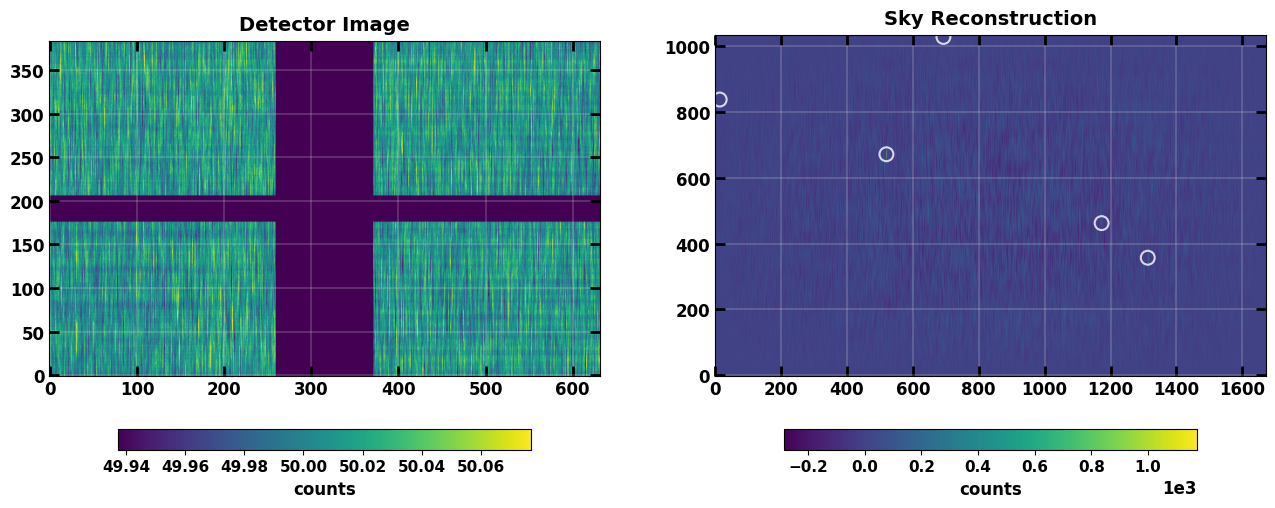

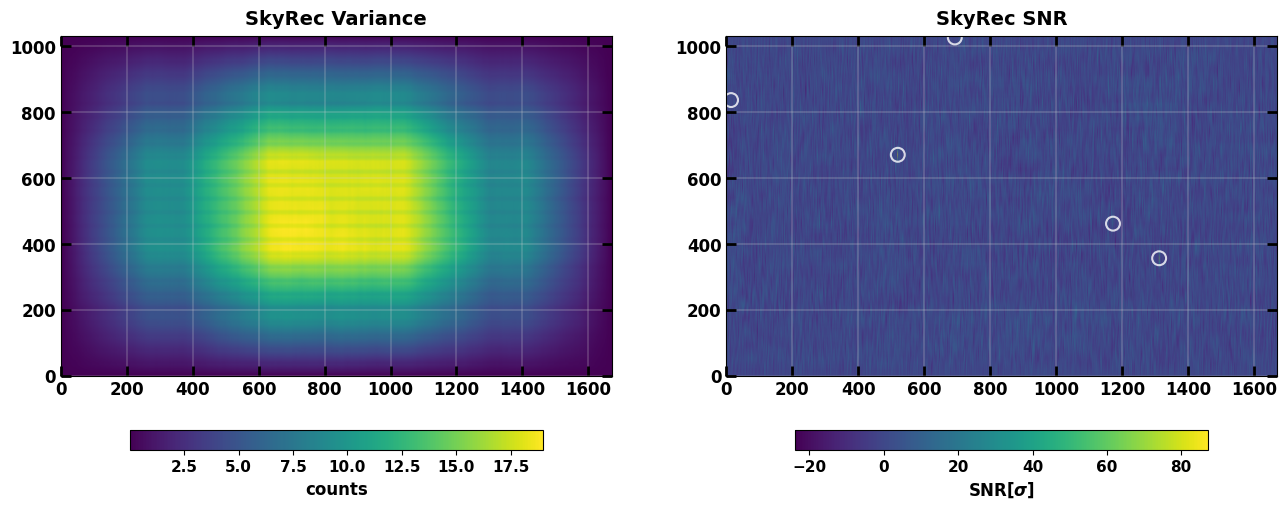

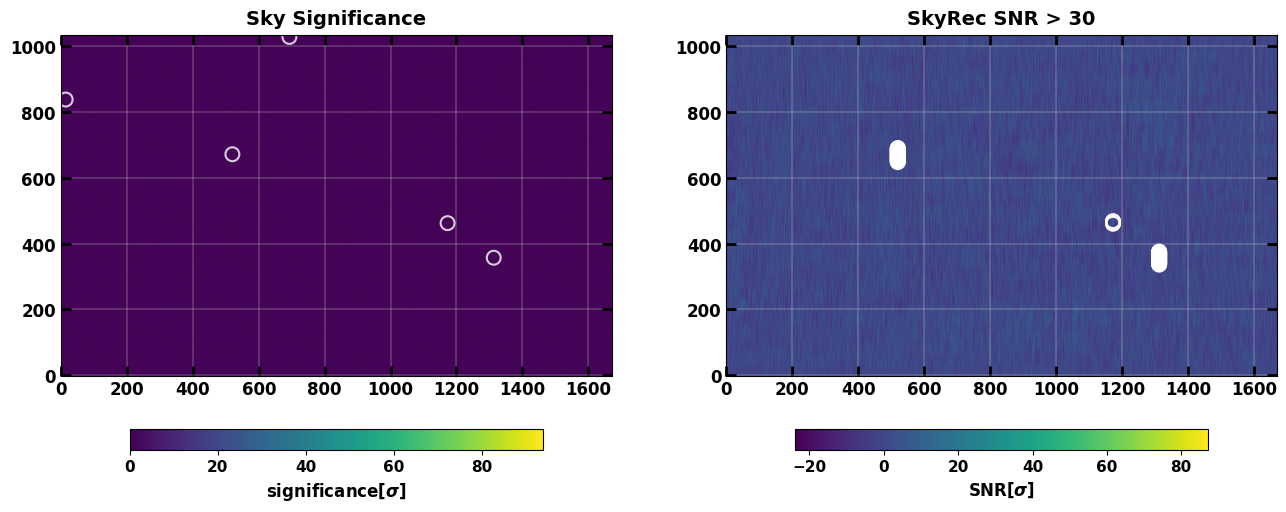

Simulated Source [0] counts: 571
Reconstructed Source [0] renorm. counts: -11

Simulated Source [1] counts: 1715
Reconstructed Source [1] renorm. counts: 791

Simulated Source [2] counts: 1559
Reconstructed Source [2] renorm. counts: 1172

Simulated Source [3] counts: 759
Reconstructed Source [3] renorm. counts: 455

Simulated Source [4] counts: 1307
Reconstructed Source [4] renorm. counts: 23



In [10]:
open_fraction = wfm.mask.sum()/wfm.mask.size

cc_detector_image = correlate(wfm.mask, sky_image, mode='valid')/wfm.mask.sum()
detector_image = cc_detector_image*wfm.bulk
skyrec = decode(wfm, detector_image)

skyrec_var = sky_variance(wfm.decoder, detector_image, wfm.bulk)/wfm.mask.sum()
skyrec_snr = snr(skyrec, skyrec_var)

plot.image_plot([detector_image, skyrec*(1 - open_fraction)/open_fraction],
                ["Detector Image", "Sky Reconstruction"],
                cbarlabel=["counts", "counts"],
                cbarlimits=[(cc_detector_image.min(), None), (None, None)],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2,
                simulated_sources=[None, sources_pos])

plot.image_plot([skyrec_var, skyrec_snr],
                ["SkyRec Variance", "SkyRec SNR"],
                cbarlabel=["counts", "SNR[$\sigma$]"],
                cbarlimits=[(None, None), (None, None)],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2,
                simulated_sources=[None, sources_pos])

thres_snr = 30
loc = np.argwhere(skyrec_snr > thres_snr).T

plot.image_plot([stats.significance(sky_image, sky_background_rate), skyrec_snr],
                ["Sky Significance", f"SkyRec SNR > {thres_snr}"],
                cbarlabel=["significance[$\sigma$]", "SNR[$\sigma$]"],
                cbarlimits=[(None, None), (None, None)],
                cbarscinot=[True]*2,
                cbarcmap=["viridis"]*2,
                simulated_sources=[sources_pos, np.dstack((loc[0], loc[1]))[0]])


for idx, pos in enumerate(sources_pos):
    print(f"Simulated Source [{idx}] counts: {sky_image[*pos]}\n"
          f"Reconstructed Source [{idx}] renorm. counts: {skyrec[*pos]*(1 - open_fraction)/open_fraction:.0f}\n")

# <center>**IROS**<center>

In [11]:
import iros as sk

In [25]:
import importlib
importlib.reload(sk)

<module 'iros' from '/home/starfloyd/PhD_Coding/MasksReconstructionTest/Img_Reconstruction_RealMasks/iros.py'>

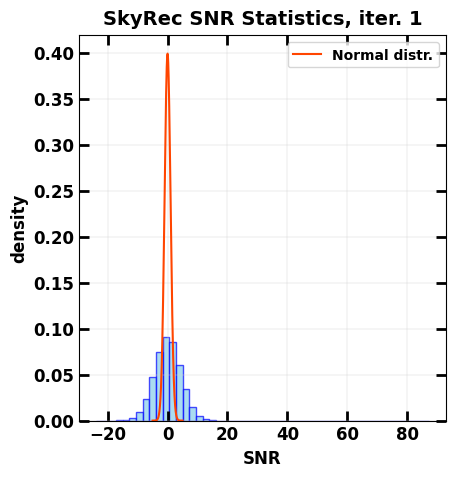

Number of outliers with SNR(σ) over 50 at iteration 1: 53


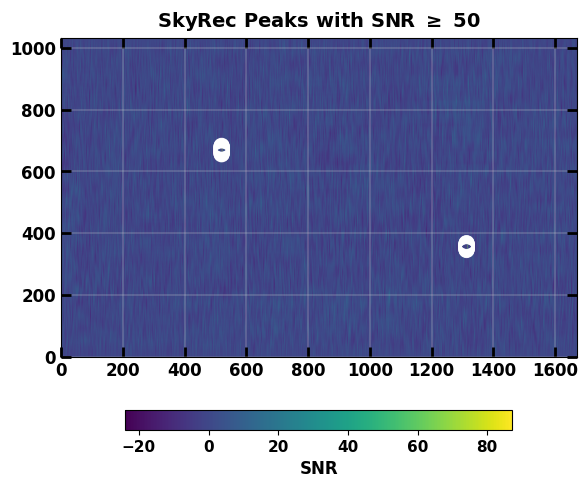

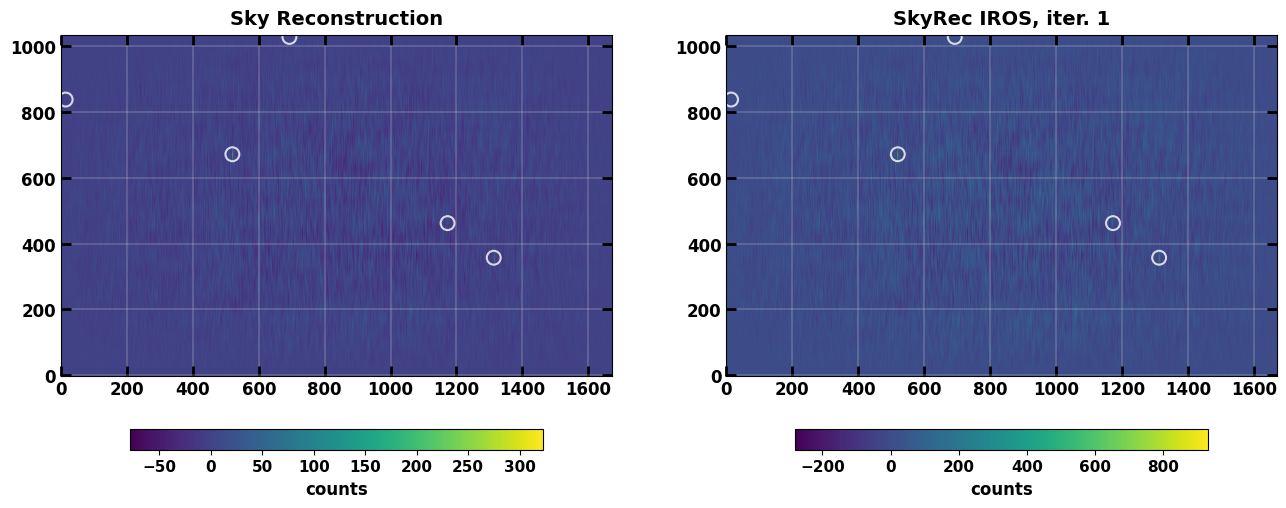

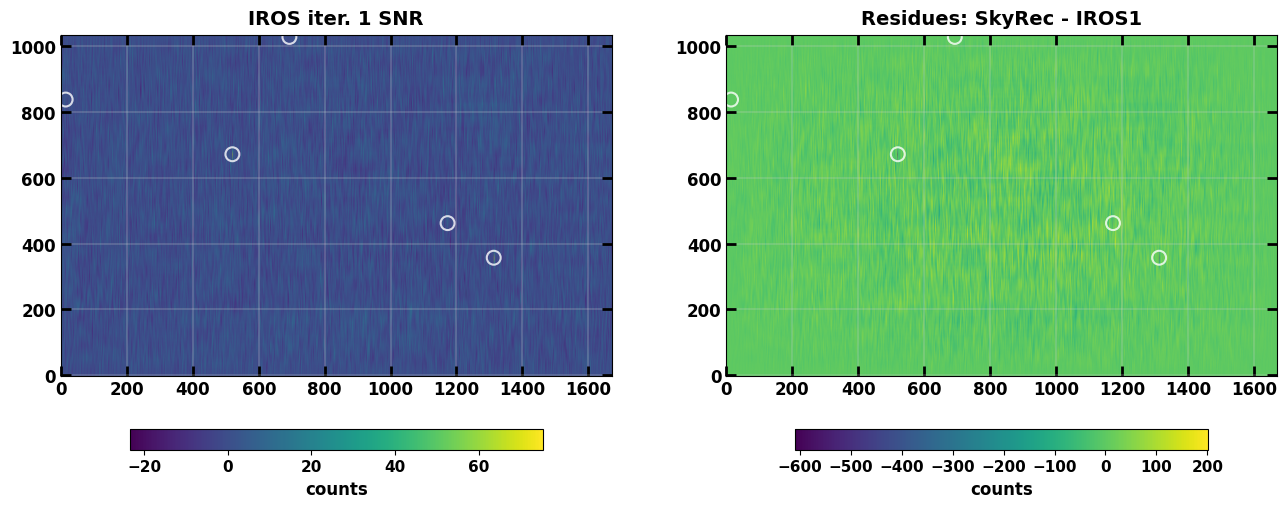

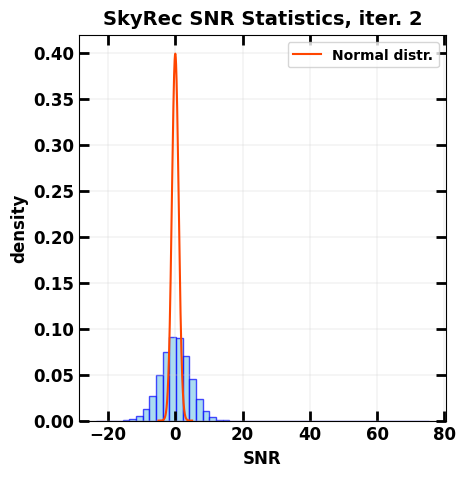

Number of outliers with SNR(σ) over 50 at iteration 2: 43


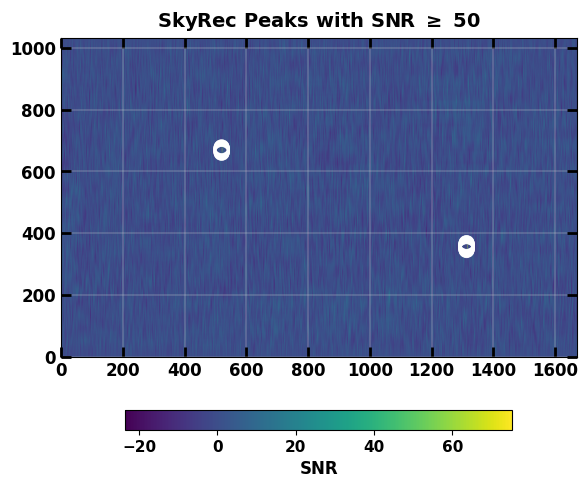

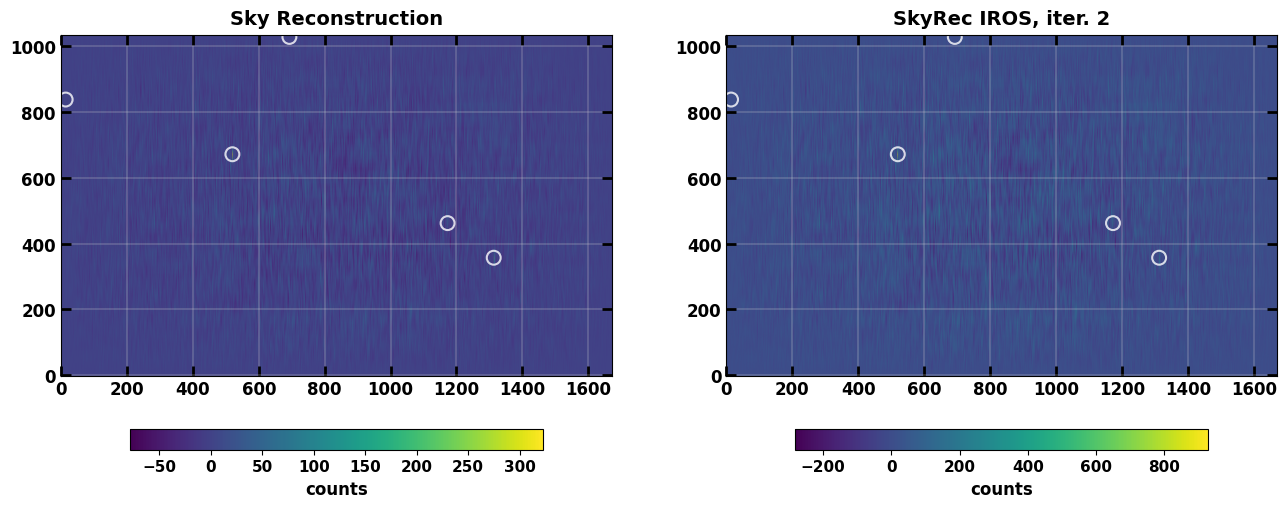

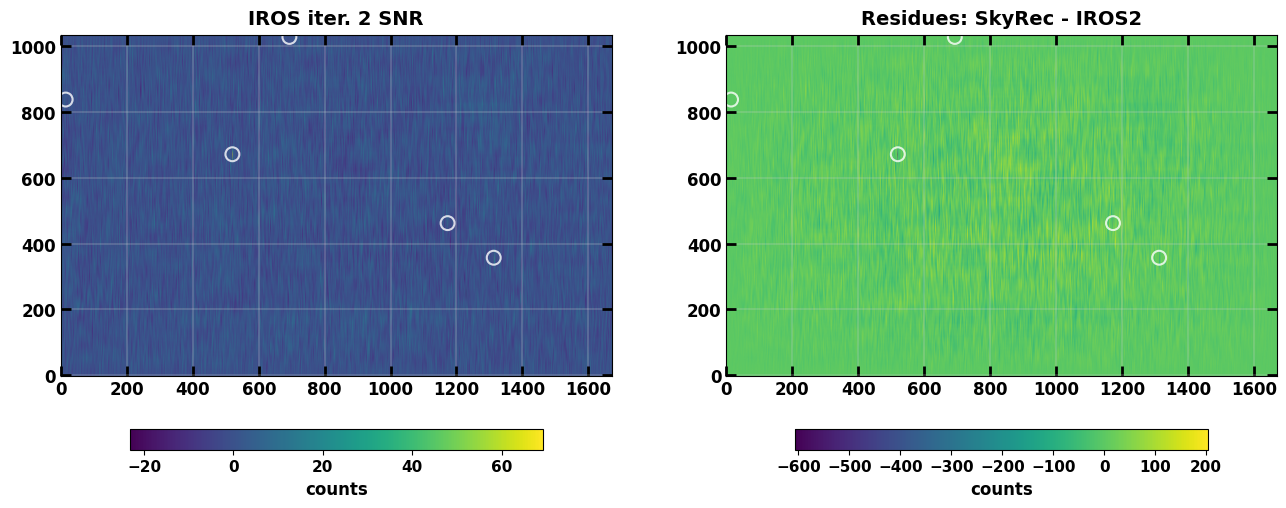

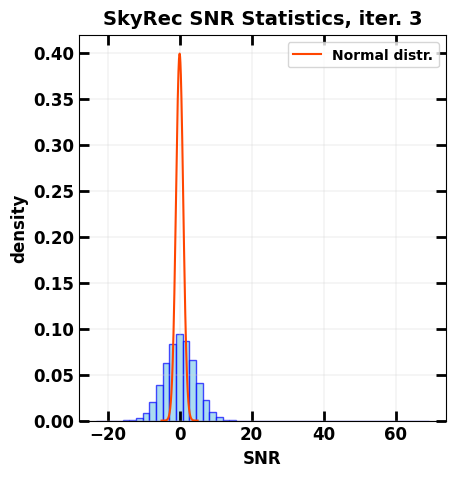

Number of outliers with SNR(σ) over 50 at iteration 3: 19


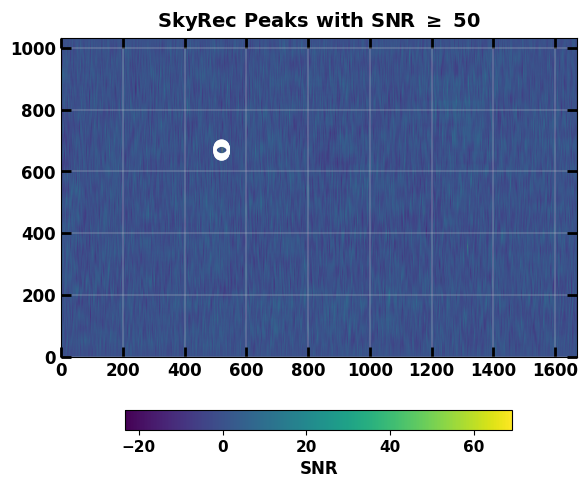

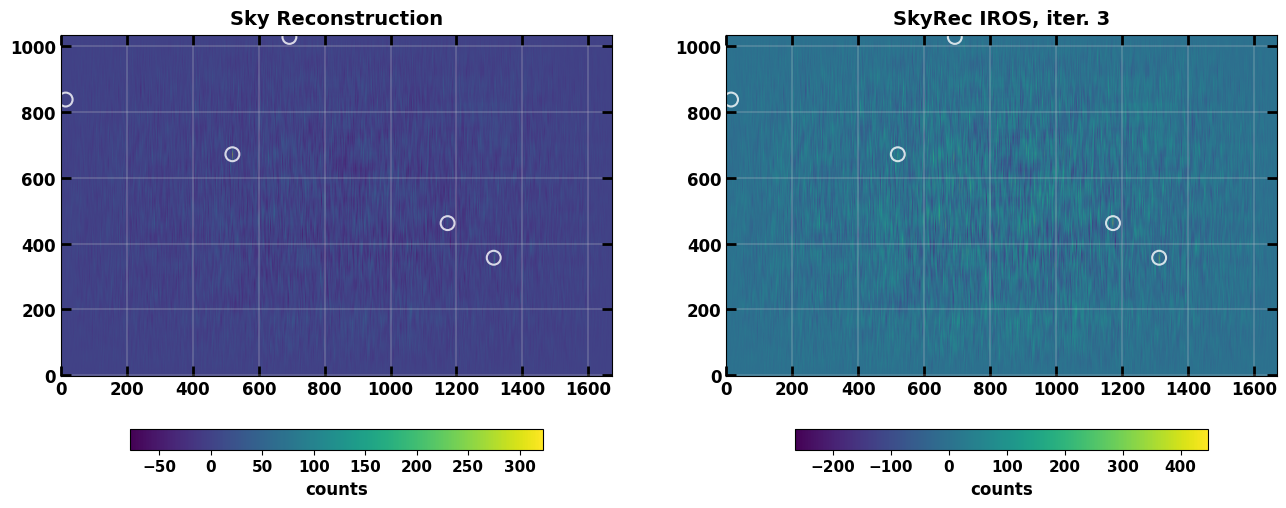

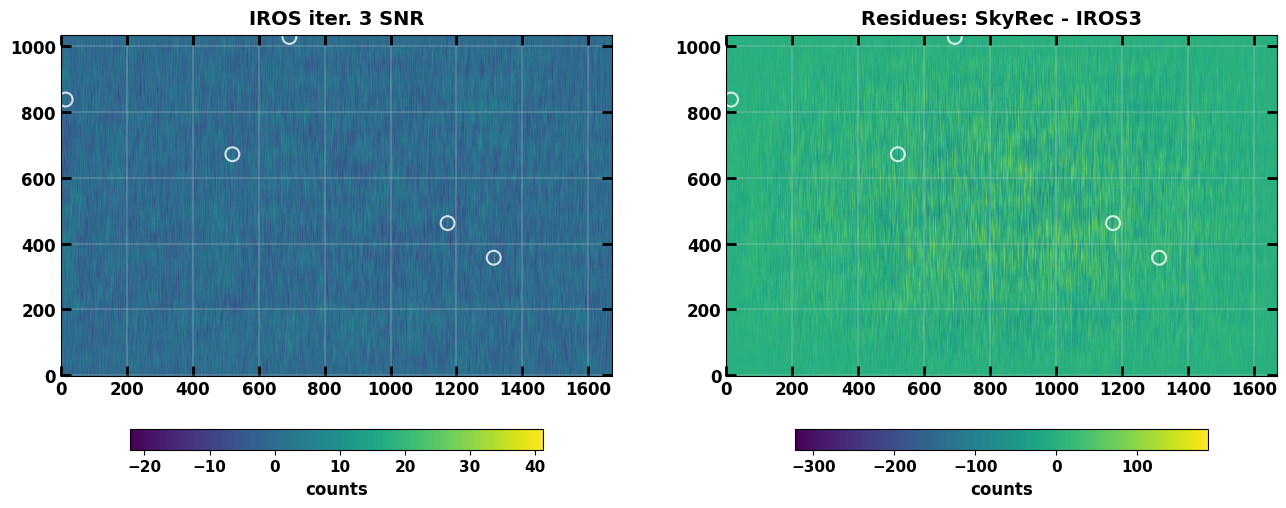

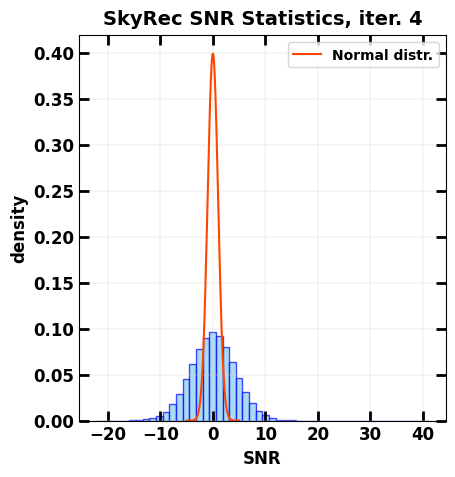

Number of outliers with SNR(σ) over 50 at iteration 4: 0


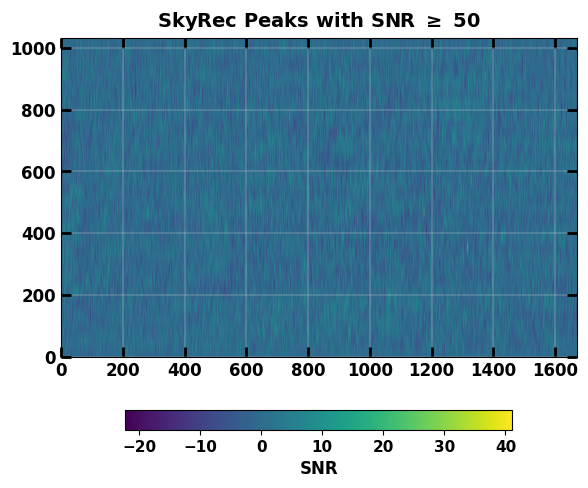

No sources detected with SNR over selected threshold...


In [12]:
threshold = 50

iros = sk.IROS(
    n_iter=len(sources_flux) + 20,
    snr_threshold=threshold,
    skyrec=skyrec,
    skyrec_snr=skyrec_snr,
    detector_image=detector_image,
    bulk_array=wfm.bulk,
    mask_array=wfm.mask,
    decoder_array=wfm.decoder,
    source_pos=sources_pos)

sources_dataset, iros_skyrec, iros_snr = iros.iterate(
    check_snr_norm=True,
    show_peaks=True,
    show_results=True)

Simulated Source S[0]: 1559
IROS Reconstructed Source S_hat[0]: 322 pm 18
|S_hat[0] - S[0]| < std(S_hat[0]): False

Simulated Source S[1]: 1715
IROS Reconstructed Source S_hat[1]: 789 pm 28
|S_hat[1] - S[1]| < std(S_hat[1]): False

Simulated Source S[2]: 1559
IROS Reconstructed Source S_hat[2]: 929 pm 30
|S_hat[2] - S[2]| < std(S_hat[2]): False

Simulated Source S[0] - pos: (837, 14), counts: 571
IROS Reconstructed Source S_hat[0] - pos: [671 520], counts: 322 pm 18
|S_hat[0] - S[0]| < std(S_hat[0]): False

Simulated Source S[1] - pos: (357, 1313), counts: 1715
IROS Reconstructed Source S_hat[1] - pos: [ 357 1313], counts: 789 pm 28
|S_hat[1] - S[1]| < std(S_hat[1]): False

Simulated Source S[2] - pos: (671, 520), counts: 1559
IROS Reconstructed Source S_hat[2] - pos: [671 520], counts: 929 pm 30
|S_hat[2] - S[2]| < std(S_hat[2]): False

Total simulated sources: 5
Total reconstructed sources: 3


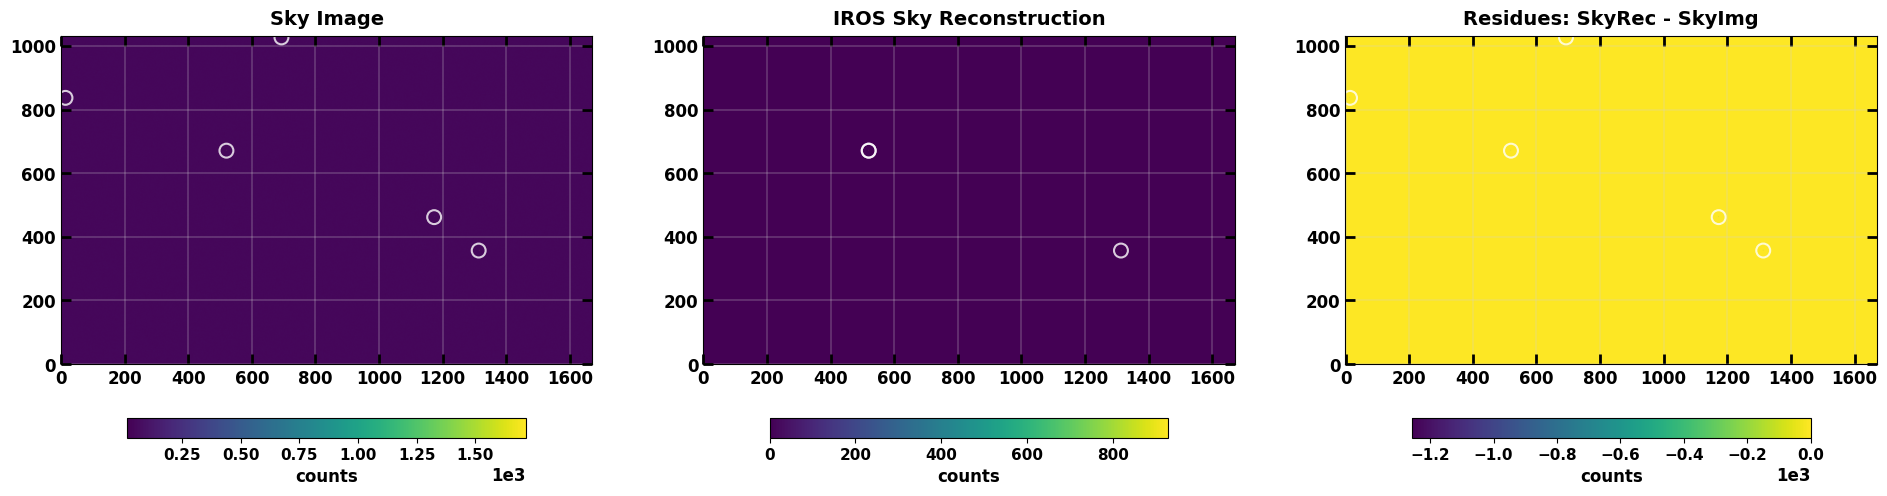

In [13]:
iros_sky_image = np.zeros(wfm.sky_shape)
for idx, loc in enumerate(sources_dataset['sources_pos']):
    iros_sky_image[*loc] = sources_dataset['sources_counts'][idx]


for i, pos, counts in zip(range(len(sources_dataset['sources_counts'])), *sources_dataset.values()):
    print(f"Simulated Source S[{i}]: {sky_image[*pos]}\n"
          f"IROS Reconstructed Source S_hat[{i}]: {counts:.0f} pm {np.sqrt(counts):.0f}\n"
          f"|S_hat[{i}] - S[{i}]| < std(S_hat[{i}]): {np.abs(counts - sky_image[*pos]) < np.sqrt(counts)}\n")


for i, pos, loc, counts in zip(range(len(sources_dataset['sources_counts'])), sources_pos, *sources_dataset.values()):
    print(f"Simulated Source S[{i}] - pos: {pos}, counts: {sky_image[*pos]}\n"
          f"IROS Reconstructed Source S_hat[{i}] - pos: {loc}, counts: {counts:.0f} pm {np.sqrt(counts):.0f}\n"
          f"|S_hat[{i}] - S[{i}]| < std(S_hat[{i}]): {np.abs(counts - sky_image[*pos]) < np.sqrt(counts)}\n")


print(f"Total simulated sources: {len(sources_flux)}\n"
      f"Total reconstructed sources: {len(sources_dataset['sources_counts'])}")


plot.image_plot([sky_image, iros_sky_image, iros_sky_image - sky_image + sky_background],
                ["Sky Image", "IROS Sky Reconstruction", "Residues: SkyRec - SkyImg"],
                cbarlabel=["counts"]*3,
                cbarcmap=["viridis"]*3,
                simulated_sources=[sources_pos, sources_dataset['sources_pos'], sources_pos])